# Retrieve data

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import time
start_notebook = time.time()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
well_name = "LLB-10"
data = pd.read_csv(f"/content/drive/MyDrive/riset-fttm-gdrive/cuml-tf-model-hydrocarbon-prediction/data/interpreted/interpreted_{well_name}.csv", sep=',')

In [5]:
df=data[['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP']]
df

,CALI,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR,ROP
0,12.415,0.044,66.597,1.218,0.4272,3.013,2.318,274.659
1,12.560,0.018,66.809,1.210,0.4326,2.916,2.290,274.659
2,12.563,0.004,65.399,1.210,0.4481,2.845,2.265,274.659
3,13.139,0.012,64.328,1.236,0.4469,2.600,2.267,274.659
4,13.397,0.031,67.245,1.239,0.4317,2.478,2.276,319.478
...,...,...,...,...,...,...,...,...
796,12.810,0.149,71.371,1.929,0.4603,3.151,2.356,147.027
797,12.733,0.155,72.914,2.032,0.4665,3.256,2.350,147.027
798,13.073,0.163,70.924,2.097,0.4723,3.258,2.345,147.027
799,12.815,0.171,69.881,1.926,0.4702,3.237,2.353,147.027


# Data Preparation

## Train/Test Splitting

In [6]:
# Misalkan 'data' adalah DataFrame Anda dan 'df' adalah fitur yang telah Anda ekstrak
X = df  # Fitur
y = data['hydrocarbon_formation_class']  # Label

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
X_train.describe()

,CALI,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR,ROP
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,12.846042,0.145117,64.793952,1.497077,0.430028,2.947128,2.340634,215.547194
std,0.439068,0.081481,7.679104,0.787070,0.046061,0.400859,0.074396,78.099711
min,11.723000,-0.059000,29.868000,0.880000,0.192200,2.003000,2.149000,22.653000
25%,12.563000,0.089000,59.811500,1.264000,0.403500,2.725000,2.296000,149.857000
50%,12.777000,0.133000,64.936500,1.314000,0.425950,2.889000,2.334000,215.314500
75%,13.073000,0.181250,69.760500,1.418500,0.463625,3.130750,2.377000,276.452000
max,14.572000,0.563000,88.665000,9.355000,0.544700,5.303000,2.729000,437.634000


## Feature Transformation

### Quantile Transformation

In [8]:
from sklearn.preprocessing import QuantileTransformer
def transform_quantile(X_train, X_test, X):
    qt_transformer = QuantileTransformer(output_distribution='normal')
    dfs = [X_train, X_test, X]
    qt_dfs = [None,None,None]
    for i, df in enumerate(dfs):
        if (i == 0): #only perform fit_transform on training data
            qt_dfs[i] = pd.DataFrame(qt_transformer.fit_transform(df))
        else:
            qt_dfs[i] = pd.DataFrame(qt_transformer.transform(df))
        qt_dfs[i].columns = df.columns.values
        qt_dfs[i].index = df.index.values
    return qt_dfs[0], qt_dfs[1], qt_dfs[2] #X_train, X_test, X_scaled

In [9]:
X_train, X_test, X = transform_quantile(X_train, X_test, X)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (640). n_quantiles is set to n_samples.
  warnings.warn(


In [10]:
X_train.describe()

,CALI,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR,ROP
count,640.000000,640.000000,6.400000e+02,640.000000,640.000000,640.000000,640.000000,640.000000
mean,0.000013,-0.000350,-5.768701e-08,-0.000004,-0.000009,-0.000045,0.000032,0.007614
std,1.031936,1.032425,1.032295e+00,1.032267,1.032284,1.032270,1.032316,1.088146
min,-5.199338,-5.199338,-5.199338e+00,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.646436,-0.675721,-6.744913e-01,-0.678188,-0.675721,-0.678188,-0.670801,-0.674504
50%,-0.003923,0.000000,0.000000e+00,-0.005884,0.000000,0.000000,-0.001961,-0.000981
75%,0.658570,0.672663,6.744913e-01,0.674491,0.674491,0.674491,0.668347,0.670801
max,5.199338,5.199338,5.199338e+00,5.199338,5.199338,5.199338,5.199338,5.199338


# Training setup

In [11]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV


sk_train_accuracy={}
sk_test_accuracy={}

cu_train_accuracy={}
cu_test_accuracy={}

sk_crossValidation_accuracy={}
cu_crossValidation_accuracy={}

sk_models = {} #sklearn models
cu_models = {} #cuml models

sk_times = {}
cu_times = {}

sk_pred = {}
cu_pred = {}

sk_pred_times = {}
cu_pred_times = {}



# Models

## SVM

In [12]:
model_name = "SVM"

In [13]:
from sklearn.svm import SVC as SklearnSVC
# Attempt to import cuML's SVC
try:
    from cuml.svm import SVC as cuMLSVC
    has_cuml = True
except ImportError:
    has_cuml = False

In [14]:
# Parameter grid for both models
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# 1) scikit-learn SVM with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnSVC(kernel='rbf'),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start
print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")

# 2) cuML SVM with the same GridSearchCV
if has_cuml:
    cu_models[model_name] = GridSearchCV(
        estimator=cuMLSVC(kernel='rbf'),
        param_grid=param_grid,
        cv=5,
        verbose=3,
        # Note: cuML estimator runs on GPU; this grid search runs on CPU orchestrating GPU calls
        n_jobs=1  # avoid multiprocessing issues with GPU
    )

    time_start = time.time()
    cu_models[model_name].fit(X_train, y_train)
    time_end = time.time()
    cu_times[model_name] = time_end - time_start
    print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
    print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
else:
    print("cuML is not installed or GPU not available. Please install RAPIDS cuML to run this benchmark.")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
scikit-learn GridSearchCV training time (SVM) : 2.24 seconds
scikit-learn Best parameters (SVM): {'C': 10, 'gamma': 'auto'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................C=0.1, gamma=scale;, score=0.828 total time=   3.6s
[CV 2/5] END ................C=0.1, gamma=scale;, score=0.852 total time=   0.0s
[CV 3/5] END ................C=0.1, gamma=scale;, score=0.859 total time=   0.0s
[CV 4/5] END ................C=0.1, gamma=scale;, score=0.812 total time=   0.0s
[CV 5/5] END ................C=0.1, gamma=scale;, score=0.867 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=auto;, score=0.812 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=auto;, score=0.852 total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=auto;, score=0.859 total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=auto;, score=0.812 total time=   0.0s
[CV 5/5] END ..............

# Prediction & Model Evaluation

--- Evaluating: SVM ---

-- scikit-learn --
Prediction Duration: 0.02 seconds
Train Accuracy: 0.9844
Test Accuracy: 0.9379
Best Cross-Validation Score: 0.9563
Confusion Matrix (Test Set):


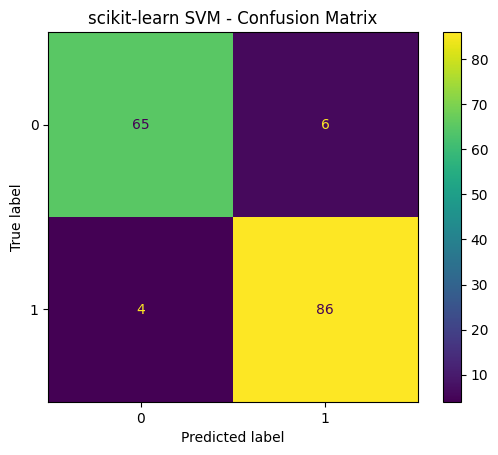

Training Duration: 2.24 seconds

-- cuML --
Prediction Duration: 0.00 seconds
Train Accuracy: 0.9844
Test Accuracy: 0.9379
Best Cross-Validation Score: 0.9563
Confusion Matrix (Test Set):


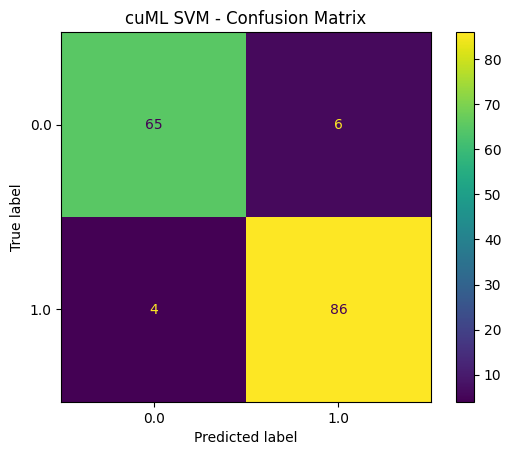

Training Duration: 5.25 seconds



Summary of Accuracies and Times:
scikit-learn Train Accuracies: {'SVM': 0.984375}
CuML Train Accuracies: {'SVM': 0.984375}
scikit-learn Test Accuracies: {'SVM': 0.937888198757764}
CuML Test Accuracies: {'SVM': 0.937888198757764}
scikit-learn Cross-Validation Accuracies: {'SVM': np.float64(0.95625)}
CuML Cross-Validation Accuracies: {'cu_SVM': np.float64(0.95625)}
scikit-learn Training Times: {'SVM': 2.2367825508117676}
cuML Training Times: {'SVM': 5.253244638442993}
scikit-learn Prediction Times: {'SVM': 0.01610851287841797}
cuML Prediction Times: {'SVM': 0.0017626285552978516}


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Comparison and Evaluation ---
model_names = list(sk_models.keys()) # Assuming cu_models will have the same keys if cuML is available

for model_name in model_names:
    print(f"--- Evaluating: {model_name} ---")

    # --- scikit-learn model ---
    if model_name in sk_models:
        print("\n-- scikit-learn --")
        best_sk_model = sk_models[model_name].best_estimator_

        # Predictions
        y_pred_train_sk = best_sk_model.predict(X_train)
        y_pred_test_sk = best_sk_model.predict(X_test)
        start_time = time.time()
        sk_pred[model_name] = best_sk_model.predict(X)
        end_time = time.time()
        sk_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {sk_pred_times[model_name]:.2f} seconds")

        # Accuracy
        train_accuracy_sk = accuracy_score(y_train, y_pred_train_sk)
        test_accuracy_sk = accuracy_score(y_test, y_pred_test_sk)
        sk_train_accuracy[model_name] = train_accuracy_sk
        sk_test_accuracy[model_name] = test_accuracy_sk
        print(f"Train Accuracy: {train_accuracy_sk:.4f}")
        print(f"Test Accuracy: {test_accuracy_sk:.4f}")

        # Cross-validation score
        cv_score_sk = sk_models[model_name].best_score_
        sk_crossValidation_accuracy[model_name] = cv_score_sk
        print(f"Best Cross-Validation Score: {cv_score_sk:.4f}")

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_sk = confusion_matrix(y_test, y_pred_test_sk)
        disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=best_sk_model.classes_)
        disp_sk.plot()
        plt.title(f"scikit-learn {model_name} - Confusion Matrix")
        plt.show()

        # Duration
        print(f"Training Duration: {sk_times[model_name]:.2f} seconds")

    # --- cuML model ---
    print("\n-- cuML --")
    if has_cuml and model_name in cu_models:
        best_cu_model = cu_models[model_name].best_estimator_

        # Predictions

        # Note: cuML predict might require cuDF DataFrame or NumPy array
        # Ensuring X_train and X_test are in a compatible format (e.g., NumPy)
        # If they are pandas DataFrames, cuML usually handles them, but explicit conversion can be safer.
        y_pred_train_cu = best_cu_model.predict(X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train)
        y_pred_test_cu = best_cu_model.predict(X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test)
        start_time = time.time()
        cu_pred[model_name] = best_cu_model.predict(X.to_numpy() if hasattr(X, 'to_numpy') else X)
        end_time = time.time()
        cu_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {cu_pred_times[model_name]:.2f} seconds")

        # If predictions are cuPy arrays, convert them to NumPy for scikit-learn metrics
        if hasattr(y_pred_train_cu, 'get'): # Check if it's a cuPy array
            y_pred_train_cu = y_pred_train_cu.get()
        if hasattr(y_pred_test_cu, 'get'): # Check if it's a cuPy array
            y_pred_test_cu = y_pred_test_cu.get()


        # Accuracy
        train_accuracy_cu = accuracy_score(y_train, y_pred_train_cu) # y_train is pandas Series, compatible
        test_accuracy_cu = accuracy_score(y_test, y_pred_test_cu)   # y_test is pandas Series, compatible
        cu_train_accuracy[model_name] = train_accuracy_cu
        cu_test_accuracy[model_name] = test_accuracy_cu
        print(f"Train Accuracy: {train_accuracy_cu:.4f}")
        print(f"Test Accuracy: {test_accuracy_cu:.4f}")

        # Cross-validation score
        cv_score_cu = cu_models[model_name].best_score_
        cu_crossValidation_accuracy[f"cu_{model_name}"] = cv_score_cu
        print(f"Best Cross-Validation Score: {cv_score_cu:.4f}")

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_cu = confusion_matrix(y_test, y_pred_test_cu)
        # Ensure classes are correctly obtained for cuML model if different from sklearn
        # For SVC, .classes_ should be available after fitting.
        disp_cu = ConfusionMatrixDisplay(confusion_matrix=cm_cu, display_labels=best_cu_model.classes_)
        disp_cu.plot()
        plt.title(f"cuML {model_name} - Confusion Matrix")
        plt.show()

        # Duration
        # if model_name in cu_times: # Check if cu_times was populated
        print(f"Training Duration: {cu_times[model_name]:.2f} seconds")
        # else:
        #     print("Training duration for cuML model not available (was it recorded correctly?).")
    else:
        print(f"cuML {model_name} was not run as cuML model for it is not available.")

    print("\n" + "="*40 + "\n")

print("\nSummary of Accuracies and Times:")
print("scikit-learn Train Accuracies:", sk_train_accuracy)
print("CuML Train Accuracies:", cu_train_accuracy)
print("scikit-learn Test Accuracies:", sk_test_accuracy)
print("CuML Test Accuracies:", cu_test_accuracy)
print("scikit-learn Cross-Validation Accuracies:", sk_crossValidation_accuracy)
print("CuML Cross-Validation Accuracies:", cu_crossValidation_accuracy)
print("scikit-learn Training Times:", sk_times)
print("cuML Training Times:", cu_times)
print("scikit-learn Prediction Times:", sk_pred_times)
print("cuML Prediction Times:", cu_pred_times)

In [16]:
# # ...existing code...
# # Cell to add for plotting

# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import numpy as np
# import pandas as pd

# # Ensure all necessary variables are defined from previous cells:
# # data, df, y, sk_pred, cu_pred, has_cuml (for cuML models)
# # X (to get the index for aligning predictions if they are numpy arrays)

# # Assuming 'DEPT' column exists in the original 'data' DataFrame
# if 'DEPT' not in data.columns:
#     print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
# else:
#     depth_column = data['DEPT']
#     feature_names = df.columns.tolist() # df contains the features used for X

#     # Prepare labels and predictions
#     true_labels = y # This is data['hydrocarbon_formation_class']

#     # Consolidate all predictions to plot
#     all_predictions_to_plot = {}
#     all_predictions_to_plot['True Labels'] = true_labels

#     for model_name, preds in sk_pred.items():
#         all_predictions_to_plot[f'SK: {model_name}'] = preds

#     if has_cuml and cu_pred:
#         for model_name, preds_cu in cu_pred.items():
#             # Ensure cuML predictions are NumPy arrays
#             if hasattr(preds_cu, 'get'): # Check if cuPy array
#                 preds_np = preds_cu.get()
#             else:
#                 preds_np = preds_cu
#             all_predictions_to_plot[f'CU: {model_name}'] = preds_np


#     # Define colors for classes
#     # Ensure true_labels is a Pandas Series to use .unique()
#     if isinstance(true_labels, np.ndarray):
#         unique_classes = np.sort(np.unique(true_labels))
#     else: # Assuming Pandas Series
#         unique_classes = np.sort(true_labels.unique())

#     # Using colors similar to the reference if possible (e.g., for 2 classes)
#     # Adjust if you have more classes or specific color preferences
#     if len(unique_classes) == 1:
#         plot_colors = ['gold']
#     elif len(unique_classes) == 2:
#         plot_colors = ['gold', 'darkorange']
#     else: # General case for more than 2 classes
#         # Use a standard colormap or define more colors
#         cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
#         plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

#     class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
#     cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])

#     # Determine number of subplots
#     num_feature_plots = len(feature_names)
#     num_classification_plots = len(all_predictions_to_plot)
#     total_plots = num_feature_plots + num_classification_plots

#     fig, axes = plt.subplots(1, total_plots, figsize=(total_plots * 2, 12), sharey=True)
#     fig.suptitle("Classification Result", fontsize=16, y=0.95)

#     current_ax_idx = 0

#     # 1. Plot feature tracks
#     for i, feature_name in enumerate(feature_names):
#         ax = axes[current_ax_idx]
#         # Ensure data[feature_name] is aligned with depth_column if data was modified
#         # Assuming data DataFrame (source of features and depth) is consistently indexed
#         ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index]) # Use X.index for alignment
#         ax.set_title(feature_name, fontsize=10)
#         ax.set_xlabel("Value", fontsize=8)
#         if current_ax_idx == 0:
#             ax.set_ylabel("DEPT (feet)", fontsize=10)
#         ax.grid(True, linestyle='--', alpha=0.7)
#         # Try to set some reasonable x-limits or let matplotlib decide
#         ax.tick_params(axis='x', labelsize=8)
#         ax.tick_params(axis='y', labelsize=8)
#         current_ax_idx += 1

#     # 2. Plot classification tracks (True Labels and Model Predictions)
#     plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

#     for title in plot_order:
#         predictions_data = all_predictions_to_plot[title]
#         ax = axes[current_ax_idx]

#         # Convert labels/predictions to integer representations for imshow
#         # Ensure predictions_data is a pandas Series or numpy array that can be mapped
#         if isinstance(predictions_data, pd.Series):
#             # If index is not aligned with X.index, reindex.
#             # Predictions from sk_pred/cu_pred should align with X.index
#             # True labels (y) should also align with X.index
#             if not predictions_data.index.equals(X.index):
#                  # This case should ideally not happen if data handling is consistent
#                  # For safety, one might try to reindex based on a common length,
#                  # but it's better to ensure upstream data alignment.
#                  # For now, assume alignment or direct use if numpy array.
#                  pass # Assuming it's aligned or will be handled
#             mapped_preds = predictions_data.map(class_to_int).fillna(-1) # fillna for robustness
#         elif isinstance(predictions_data, np.ndarray):
#             # If numpy array, assume it's already aligned with X and therefore depth_column
#             # Create a temporary Series for mapping if it's not already integer-coded
#             # This assumes the numpy array 'predictions_data' corresponds to the order of 'unique_classes'
#             # or can be mapped using class_to_int
#             temp_series = pd.Series(predictions_data, index=X.index) # Give it an index for mapping
#             mapped_preds = temp_series.map(class_to_int).fillna(-1)
#         else:
#             print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
#             current_ax_idx +=1
#             continue

#         labels_int = mapped_preds.values.reshape(-1, 1)

#         # Handle cases where some classes in predictions might not be in original y's unique_classes
#         # For imshow, values should be 0 to N-1 where N is number of colors in cmap_listed
#         # We use -1 for fillna, which will be outside the typical 0 to N-1 range.
#         # Matplotlib's imshow with a ListedColormap handles out-of-range values by making them transparent
#         # or using under/over colors if set. Here, we rely on values being in range [0, num_colors-1].
#         # We should ensure class_to_int maps to valid indices for cmap_listed.

#         vmin = 0
#         vmax = len(plot_colors) - 1

#         ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
#                   extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
#                   interpolation='none', vmin=vmin, vmax=vmax)

#         if title == 'True Labels':
#              ax.set_title("True Class\n(hydrocarbon_formation_class)", fontsize=10)
#         else:
#             ax.set_title(title, fontsize=10)
#         ax.set_xticks([])
#         ax.set_xlabel("") # No x-label for classification tracks
#         ax.tick_params(axis='y', labelsize=8)
#         current_ax_idx += 1

#     # Invert y-axis for all subplots (depth increasing downwards)
#     axes[0].invert_yaxis()

#     # Add a legend for the classification colors
#     # Create patches for the legend
#     if unique_classes is not None and len(unique_classes) > 0:
#         patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
#         # Shorten class names if they are long strings for the legend
#         legend_labels = [str(cls) for cls in unique_classes]
#         fig.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")


#     plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to make space for suptitle and legend
#     plt.show()

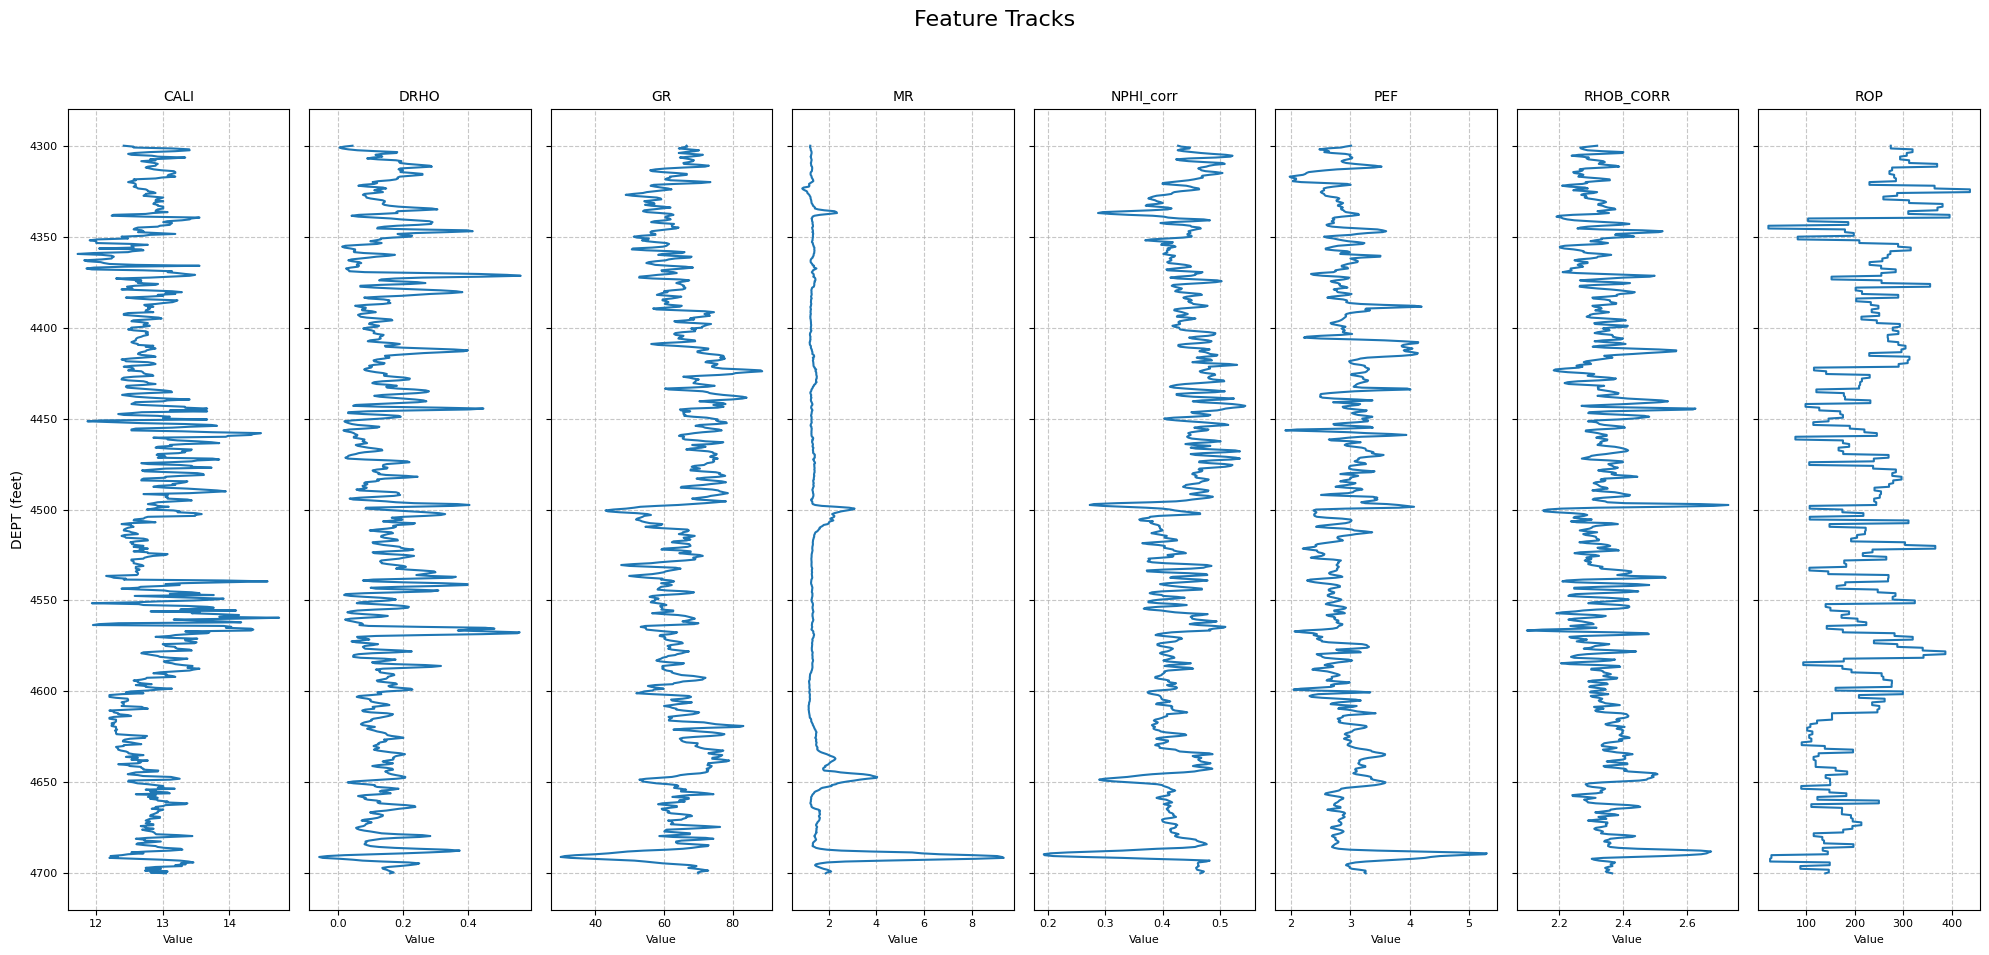

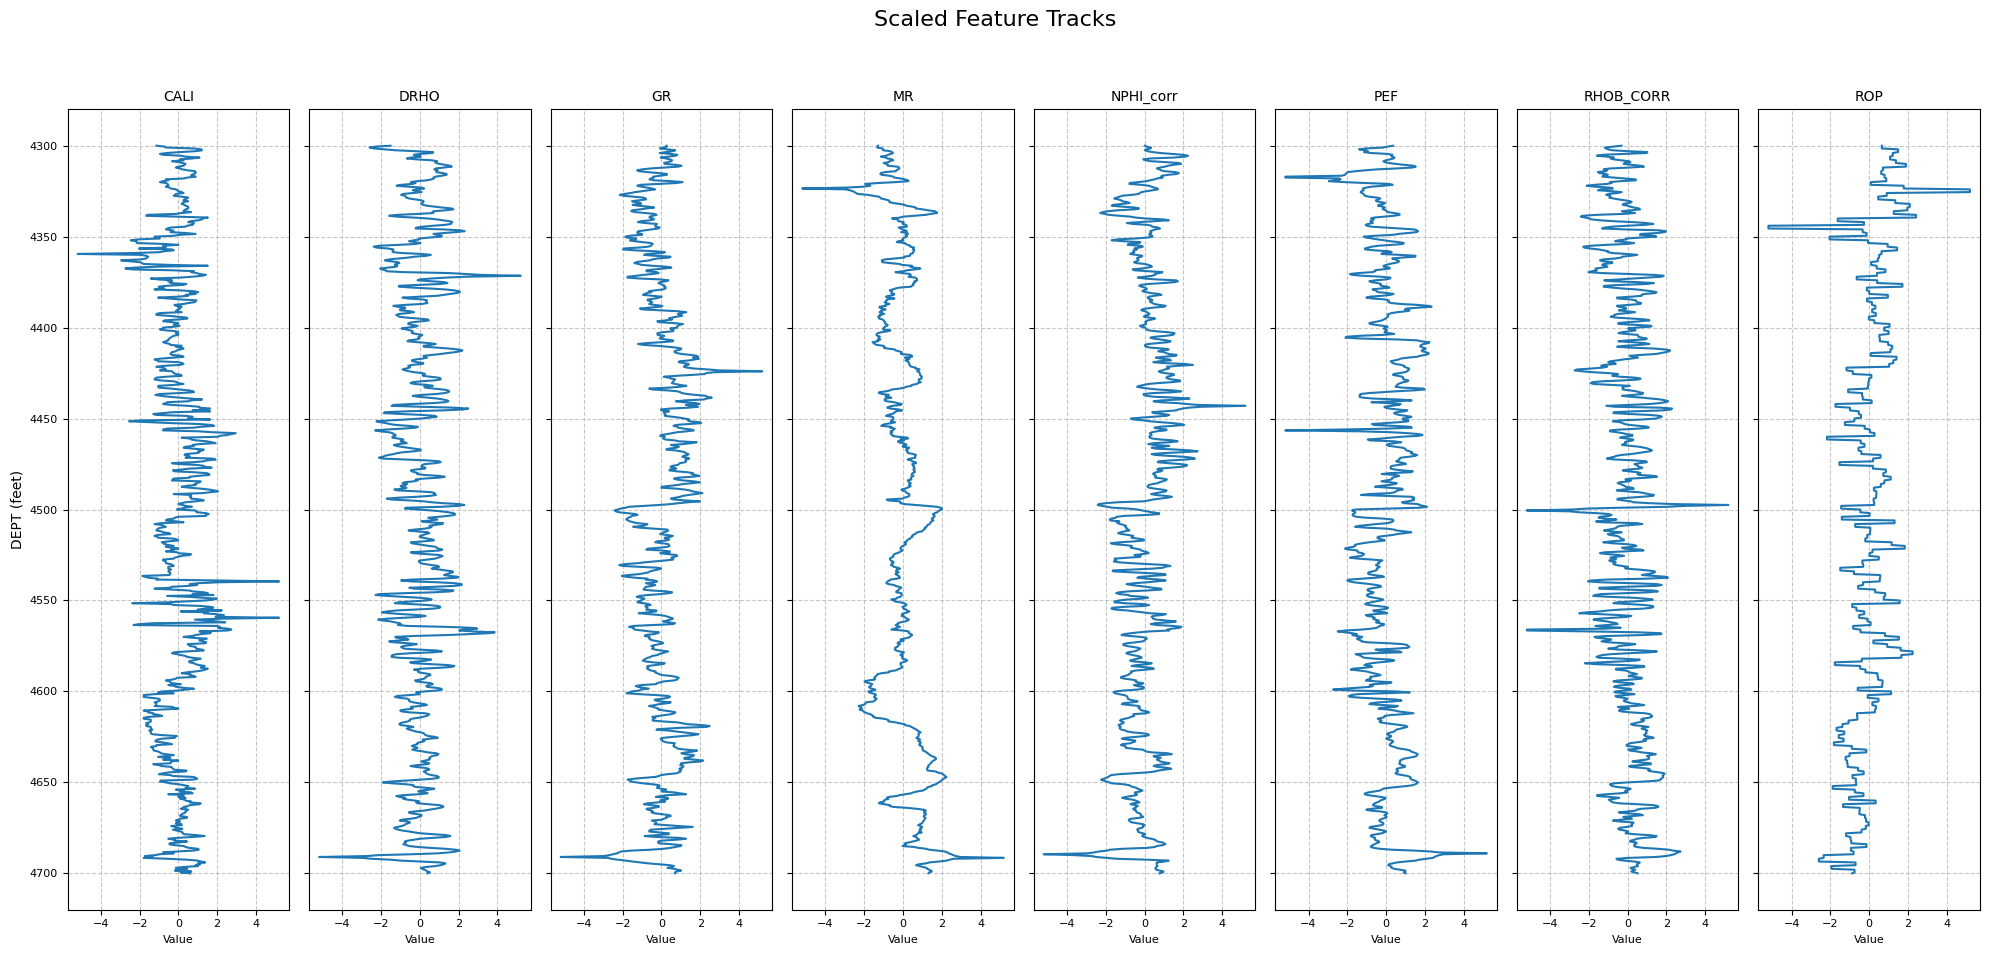

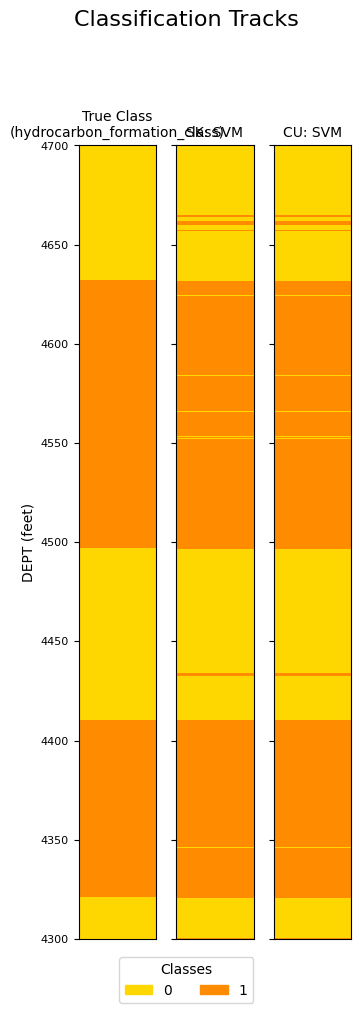

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# Ensure all necessary variables are defined from previous cells:
# data, df, y, sk_pred, cu_pred, has_cuml (for cuML models)
# X (to get the index for aligning predictions if they are numpy arrays)

if 'DEPT' not in data.columns:
    print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
else:
    depth_column = data['DEPT']
    feature_names = df.columns.tolist()

    # Prepare labels and predictions (same as before)
    true_labels = y
    all_predictions_to_plot = {}
    all_predictions_to_plot['True Labels'] = true_labels
    for model_name, preds in sk_pred.items():
        all_predictions_to_plot[f'SK: {model_name}'] = preds
    if has_cuml and cu_pred:
        for model_name, preds_cu in cu_pred.items():
            if hasattr(preds_cu, 'get'):
                preds_np = preds_cu.get()
            else:
                preds_np = preds_cu
            all_predictions_to_plot[f'CU: {model_name}'] = preds_np

    # Define colors for classes (same as before)
    if isinstance(true_labels, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels))
    else:
        unique_classes = np.sort(true_labels.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])


    # --- Figure 1: feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for feature tracks.")

    # --- Figure 2: scaled feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(X[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for scaled feature tracks.")

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_to_plot)
    if num_classification_plots > 0:
        # Adjust figsize: width per plot can be smaller for classification tracks
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle("Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                if not predictions_data.index.equals(X.index):
                    # This should ideally not happen with consistent data handling
                    # For safety, one might reindex or ensure alignment upstream
                    print(f"Warning: Index mismatch for {title}. Plotting may be incorrect.")
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=X.index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0: # Set Y-axis label only for the first plot in this figure
                ax.set_ylabel("DEPT (feet)", fontsize=10)


        axes_class[0].invert_yaxis()

        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print("No classification data to plot.")


In [18]:
from google.colab import runtime
runtime.unassign()